In [180]:
print(__doc__)
import math

import numpy as np
import numpy_indexed as npi
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

pd.options.display.float_format = "{:.1f}".format

Automatically created module for IPython interactive environment


In [181]:
def retrieve_data_recid():
    
    attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree']
    bias = 'race'
    target = 'two_year_recid'

    np.random.seed(42)

    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/RecidivismData_Normalized.csv", sep=',')
    data_col = data.columns
    df = data[(data[bias]==2)|(data[bias]==3)].copy().values

    kf = KFold(n_splits=4) #differ from original method
    for train_index, test_index in kf.split(df):
        train, test = df[train_index], df[test_index]
        # print("Size of X_train_full, X_test:", train.shape, test.shape)

    df_train = pd.DataFrame(data=train, columns=data_col)
    df_test = pd.DataFrame(data=test, columns=data_col)

    labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5, random_state = 42)) # ten sample in total labeled initially
    df_X_labeled = labeled[attributes]
    df_y_labeled = labeled[target]
    X_labeled = df_X_labeled.values
    y_labeled = df_y_labeled.values.astype('int64')
    b_labeled = labeled[bias].values-2
    (row_size, col_size) = X_labeled.shape

    unlabeled = df_train.drop(df_X_labeled.index)
    df_X_unlabeled = unlabeled[attributes]
    df_y_unlabeled = unlabeled[target]
    X_unlabeled = df_X_unlabeled.values
    y_unlabeled = df_y_unlabeled.values.astype('int64')
    b_unlabeled = unlabeled[bias].values-2

    X_test = df_test[attributes].values
    y_test = df_test[target].values
    y_test=y_test.astype('int')
    b_test = df_test[bias].values-2

    X_fair_est = X_unlabeled
    y_fair_est = y_unlabeled
    b_fair_est = b_unlabeled
    
    return (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est)

In [182]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass

class LogModel(BaseModel):

    def fit_predict(self, X_labeled, y_labeled, X_test, y_test):
        self.classifier = LogisticRegression(
            solver='liblinear'
            )
        self.classifier.fit(X_labeled, y_labeled)
        # self.y_test_predicted = self.classifier.predict(X_test)
        # self.y_unlabeled_predicted = self.classifier.predict(X_unlabeled)
        self.y_test_score = self.classifier.score(X_test, y_test)
        return (X_labeled, X_test, self.y_test_score)

In [183]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_labeled, y_labeled, X_test, y_test):
        (X_labeled, X_test, self.y_test_score) = \
            self.model_object.fit_predict(X_labeled, y_labeled, X_test, y_test)
        return (X_labeled, X_test)

    def get_test_accuracy(self, i):
        classif_rate = self.y_test_score * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print("Accuracy rate is %f " % (classif_rate))

In [184]:
def normalizer(e_loss, f_loss):
    e_loss = np.reshape(e_loss, (1,len(e_loss)))
    f_loss = np.reshape(f_loss, (1,len(f_loss)))
    e_scaled = preprocessing.normalize(e_loss)
    # e_scaled=((e_loss-e_loss.min())/(e_loss.max()-e_loss.min()))
    f_scaled = preprocessing.normalize(f_loss)
    # f_scaled=((f_loss-f_loss.min())/(f_loss.max()-f_loss.min()))
    return (e_scaled, f_scaled)

In [185]:
def log_loss(probas_val):
    
    eps = np.finfo(probas_val.dtype).eps
    probas_val = np.clip(probas_val, eps, 1 - eps)
    e_loss = (-probas_val * np.log2(probas_val)).sum(axis=1)

    return e_loss

In [186]:
# separation \ Equal opportunity - Hardt, Price, Srebro (2016)

def stats_parity(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0=X_fair_est[(b_fair_est==0)].shape[0]
    b1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1=X_fair_est[(b_fair_est==1)].shape[0]

    f_loss=(b0p1/b0)-(b1p1/b1)
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    
    return f_loss

def eqops(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    f_loss=(b0y1p1/b0y1)-(b1y1p1/b1y1)
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    
    return f_loss

def eqods(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=abs((b0y0p1/b0y0)-(b1y0p1/b1y0))
    tpr_loss=abs((b0y1p1/b0y1)-(b1y1p1/b1y1))


    f_loss = (fpr_loss+tpr_loss)/2 # temporary solution
    
    return f_loss 

def disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p0=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p0=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=abs((b0y0p1/b0y0)-(b1y0p1/b1y0))
    fnr_loss=abs((b0y1p0/b0y1)-(b1y1p0/b1y1))


    f_loss = (fpr_loss+fnr_loss)/2 # temporary solution
    
    return f_loss 
    

In [187]:
# selecting fairness criteria

def fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=None, criteria=0):

    if criteria == 'equal_opportunity':
        return eqops(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'statistical_parity':
        return stats_parity(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'disparate_mistreatment':
        return disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'equalized_odds':
        return eqods(X_fair_est, y_fair_est, b_fair_est, classifier)

In [188]:
def unfairness_reduction_sampling(query_size, X_unlabeled, X_labeled, y_labeled, classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, step, criteria):
    # further to be defined, now assume only fairness loss
    # query size used here
    div = 0

    unlabeled_size = len(X_unlabeled)
    f_loss = np.zeros(unlabeled_size)
    for i in range(unlabeled_size):
        f_loss_temp = []
        for j in range(2):
            X_labeled_temp = np.append(X_labeled, [X_unlabeled[i]], axis = 0)
            y_labeled_temp = np.append(y_labeled, [j], axis = 0)
            classifier_temp = LogisticRegression(solver='liblinear').fit(X_labeled_temp, y_labeled_temp)
            f_loss_temp = np.append(f_loss_temp, fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=classifier_temp, criteria=criteria))
            f_loss_temp[np.isnan(f_loss_temp)] = 0
            
        proba_0 = classifier.predict_proba(X_unlabeled)[i][0]
        proba_1 = 1 - proba_0
        f_loss[i] = (f_loss_temp).dot([proba_0, proba_1])

    e_loss = log_loss(probas_val)

    e_scaled, f_scaled = normalizer(e_loss, f_loss)
    f_scaled[np.isnan(f_scaled)] = 0

    loss = div*(e_loss)+(1-div)*f_loss
    
    selection = np.argsort(loss)[::-1][:step]

    return selection

In [189]:
def pre_filter(X_data, b_data, y_data, budget): 

    temp_columns = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree','race','two_year_recid']
    np.random.seed(84)

    # print("Debug data:", X_data.shape, b_data.shape, y_data.shape)
    temp_data = np.c_[X_data, b_data, y_data]
    temp_df = pd.DataFrame(data=temp_data, columns=temp_columns)
    candidates_data = temp_df.groupby('race', group_keys=False).apply(lambda x: x.sample(n=math.ceil(budget/2), random_state = 84))
    # print("Debug ceil:", math.ceil(budget/2))
    # print("Debug cand:", candidates)
    candidates_index = candidates_data.index.values
    # print("Debug index:", candidates_index.shape, candidates_index)

    return candidates_index

In [190]:
class active_learning(object):

    def __init__(self, step, budget, model_object, criteria):
        self.step = step
        self.budget = budget
        self.model_object = model_object
        # self.sample_selection_function = selection_function
        self.criteria = criteria
        
    def run(self, X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option):
  
        self.clf_model = TrainModel(self.model_object)
        (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(active_iteration)

        self.query_size = len(X_labeled)
        fairness = []
        fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))

        while self.query_size <= self.budget-self.step:

            active_iteration += 1
            self.query_size += self.step

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_unlabeled)
            
            # print("Debug predicted:", y_unlabeled_predicted.shape)
            # print("Debug probas_val:", probas_val.shape)

            if sub_option == "Pre_filter":

                candidates_index = pre_filter(X_unlabeled, b_unlabeled, y_unlabeled, self.budget)
                
                uncertain_samples = unfairness_reduction_sampling(self.query_size, X_unlabeled[candidates_index], X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est, y_fair_est, b_fair_est, probas_val[candidates_index], self.step, self.criteria)

                print("Uncertain_samples:", uncertain_samples)

            elif sub_option == "No_filter": 

                uncertain_samples = unfairness_reduction_sampling(self.query_size, X_unlabeled, X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, self.step, self.criteria)

                print("Uncertain_samples:", uncertain_samples)

            elif sub_option == "Filter_only":

                uncertain_samples = pre_filter(X_unlabeled, b_unlabeled, y_unlabeled, self.step)
                
                print("Uncertain_samples:", uncertain_samples)
            # print("Debug shape of X_unlabeled and loss:", selection)

            X_labeled = np.concatenate((X_labeled, X_unlabeled[uncertain_samples]))
            y_labeled = np.concatenate((y_labeled, y_unlabeled[uncertain_samples]))
            X_unlabeled = np.delete(X_unlabeled, uncertain_samples, axis=0)
            y_unlabeled = np.delete(y_unlabeled, uncertain_samples, axis=0)
            b_unlabeled = np.delete(b_unlabeled, uncertain_samples, axis=0)

            (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
            fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
            self.clf_model.get_test_accuracy(active_iteration)

        return self.clf_model.accuracies, fairness

In [191]:
def non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled,y_labeled, X_test, y_test, b_test, budget, step, unfairness_criteria): 

    initial_X_train = X_labeled
    initial_y_train = y_labeled
    nonal_X_train = X_unlabeled
    nonal_y_train = y_unlabeled
    nonal_X_test = X_test
    nonal_y_test = y_test
    nonal_b_test = b_test
    nonal_fairness = []

    nonal_accuracies=[]

    classifier_nonal = LogisticRegression(
            solver='liblinear'
            )

    classifier_nonal.fit(initial_X_train, initial_y_train)
    initial_y_pred = classifier_nonal.predict(nonal_X_test)
    nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
    nonal_accuracies.append(accuracy_score(nonal_y_test, initial_y_pred)*100)

    for i in np.arange(init_index+step,budget+1,step):
        classifier_nonal.fit(nonal_X_train[:i], nonal_y_train[:i])
        nonal_y_pred = classifier_nonal.predict(nonal_X_test)
        nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
        nonal_accuracies.append(accuracy_score(nonal_y_test, nonal_y_pred)*100)

    return nonal_accuracies, nonal_fairness

In [192]:
def experiment(model,budget,step,criteria,sub_option=False):
    
    (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est) = retrieve_data_recid()
    init_index = len(X_labeled)
        
    act_alg = active_learning(step, budget, model, criteria)

    accuracies, fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option)

    # print('Fairness:', fairness)

    nonal_accuracies, nonal_fairness = non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled, y_labeled, X_test, y_test, b_test, budget, step, criteria)

    # print("active_accuracies",accuracies)
    # print("nonactive_accuracies",nonal_accuracies)
    
    x_axis = np.arange(init_index,budget+1,step)
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Fairness and accuracy metrics')
    ax1.plot(x_axis, fairness, color='r', label='active')
    ax1.plot(x_axis, nonal_fairness, color='b', label='non-active')
    ax1.legend()
    ax2.plot(x_axis, accuracies, color='r', label='active')
    ax2.plot(x_axis, nonal_accuracies, color='b', label='non-active')
    ax2.legend()
    ax1.set_xlabel('Sample size')
    ax1.set_ylabel('Unfairness')
    ax2.set_ylabel('Accuracies')


    plt.show()

--------------------------------
Iteration: 1
Accuracy rate is 57.629428 
Uncertain_samples: [390 307  76 466 303 449 355 464 116 282 485 356 224 493 166 456 316 377
 482 256 369 427 487 211 131 301 276 463 289  42 486 174 306 406  32 288
 287 378 483 446 389 138 414 108 127 268 125 143 110  18]
--------------------------------
Iteration: 2
Accuracy rate is 58.991826 
Uncertain_samples: [385 218 359 333 424 427 162 439 129 461  16 429 344   8 132 138 375 374
 447 346 121 436 470 469 235  23 389  43 416 180 157  45 327 232  65 298
 103  51 410 191 271 276 272 107  53 402 249 472  99 462]
--------------------------------
Iteration: 3
Accuracy rate is 59.332425 
Uncertain_samples: [314 407 465 446 484 139 413 302 497 396 361 383 442 350 397 182  75   2
 250  31 457 431 402  99 105 180  69 472  11  59 280 432 332 388 458 297
 485 400 353 274 194 251  36 422 176 301  10 328 188 264]
--------------------------------
Iteration: 4
Accuracy rate is 60.899183 
Uncertain_samples: [390 388 170 352

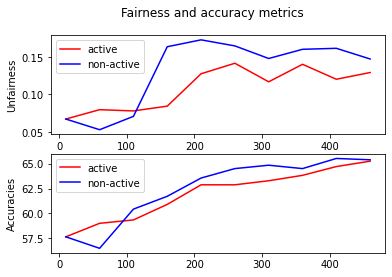

In [193]:
experiment(LogModel,500,50,"equalized_odds","Pre_filter")